<a href="https://colab.research.google.com/github/FredLongo/Big-Data-Analytics-Project/blob/main/Big_Data_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analitics
## Team Project
### Team Members
*   Alfredo Longo
*   Chandramouli Prabhakaran  
*   Cody Zehner
*   Sashank Ganapathy Subramaniam  

### Description
This Project is used to see if we can predict Bitcoin Stock Prices.  In this project we try Several diffrent things to see what can produce the best result.

* We try Two diffrent Time series Model One just one layer and one having three layers

* We also try two diffrent configeration for the (candlestick size) a ten day frame and a 100 day frame

* To give the model more comparitive information to train with we added a Maket indicator to the stock.  We do this so it can have a sence of what the overall market is doing for that day.




#Code Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install pandas_ta

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [4]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2016-01-01',   # Bitcon only has info back to mid 2015
                 end_date='2024-06-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])
        self.y_test_trend = [0]
        self.y_pred_trend = [0]
        self.scaler = None


        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()


    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)

        # Save Processed input to CSV file for Logging
        current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Data/Input_Data_Processed_{current_datetime}.csv'
        self.data.to_csv(filename , index=False)

    def reverse_scaling(self, data):
        return self.scaler.inverse_transform(data)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        self.scaler = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to our data to make it between 0 and `
        self.data_set_scaled = self.scaler.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph
        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Mean Absolute Error
          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')

          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show



    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [5]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Big Data Analytics/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [6]:
#Indicators    = '^DJI,^BSESN,^BVSP'
Indicators    = '^DJI'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]


#AMD
#Ticker = ['ADM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#MSI
Ticker = ['BTC']
frame_days = [10,100]
LSTM_layers = [1,2]

#XOM
#Ticker = ['XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]



Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} model(s)')


Testing 4 model(s)


In [7]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L1___________
Start Time:2024-06-23 14:44:44.787782
Epoch 1/30
48/48 - 6s - loss: 0.0422 - mae: 0.1716 - val_loss: 0.0863 - val_mae: 0.2528 - 6s/epoch - 121ms/step
Epoch 2/30
48/48 - 1s - loss: 0.0319 - mae: 0.1506 - val_loss: 0.1111 - val_mae: 0.3014 - 730ms/epoch - 15ms/step
Epoch 3/30
48/48 - 1s - loss: 0.0363 - mae: 0.1647 - val_loss: 0.1011 - val_mae: 0.2890 - 754ms/epoch - 16ms/step
Epoch 4/30
48/48 - 1s - loss: 0.0315 - mae: 0.1563 - val_loss: 0.0852 - val_mae: 0.2644 - 868ms/epoch - 18ms/step
Epoch 5/30
48/48 - 1s - loss: 0.0253 - mae: 0.1354 - val_loss: 0.0710 - val_mae: 0.2430 - 813ms/epoch - 17ms/step
Epoch 6/30
48/48 - 1s - loss: 0.0161 - mae: 0.1046 - val_loss: 0.0488 - val_mae: 0.1982 - 746ms/epoch - 16ms/step
Epoch 7/30
48/48 - 1s - loss: 0.0111 - mae: 0.0886 - val_loss: 0.0350 - val_mae: 0.1667 - 724ms/epoch - 15ms/step
Epoch 8/30
48/48 - 0s - loss: 0.0067 - mae: 0.0677 - val_loss: 0.0221 - val_mae: 0.1296 - 423ms/epoch - 9ms/step
Epoch 9/30
48/48 - 0

[*********************100%%**********************]  2 of 2 completed


___________BTC_F10_L2___________
Start Time:2024-06-23 14:45:13.759133
Epoch 1/30
48/48 - 8s - loss: 0.1957 - mae: 0.3452 - val_loss: 0.0832 - val_mae: 0.2689 - 8s/epoch - 166ms/step
Epoch 2/30
48/48 - 1s - loss: 0.0800 - mae: 0.2416 - val_loss: 0.0975 - val_mae: 0.2936 - 617ms/epoch - 13ms/step
Epoch 3/30
48/48 - 1s - loss: 0.0349 - mae: 0.1608 - val_loss: 0.0781 - val_mae: 0.2596 - 527ms/epoch - 11ms/step
Epoch 4/30
48/48 - 1s - loss: 0.0162 - mae: 0.1055 - val_loss: 0.0705 - val_mae: 0.2458 - 715ms/epoch - 15ms/step
Epoch 5/30
48/48 - 1s - loss: 0.0143 - mae: 0.0988 - val_loss: 0.0616 - val_mae: 0.2283 - 566ms/epoch - 12ms/step
Epoch 6/30
48/48 - 1s - loss: 0.0129 - mae: 0.0918 - val_loss: 0.0563 - val_mae: 0.2174 - 626ms/epoch - 13ms/step
Epoch 7/30
48/48 - 0s - loss: 0.0115 - mae: 0.0861 - val_loss: 0.0496 - val_mae: 0.2027 - 429ms/epoch - 9ms/step
Epoch 8/30
48/48 - 0s - loss: 0.0104 - mae: 0.0831 - val_loss: 0.0434 - val_mae: 0.1884 - 447ms/epoch - 9ms/step
Epoch 9/30
48/48 - 0s

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L1___________
Start Time:2024-06-23 14:45:41.936396
Epoch 1/30
44/44 - 4s - loss: 0.1328 - mae: 0.2832 - val_loss: 0.0234 - val_mae: 0.1296 - 4s/epoch - 90ms/step
Epoch 2/30
44/44 - 1s - loss: 0.0378 - mae: 0.1578 - val_loss: 0.0108 - val_mae: 0.0807 - 1s/epoch - 30ms/step
Epoch 3/30
44/44 - 2s - loss: 0.0196 - mae: 0.1129 - val_loss: 0.0054 - val_mae: 0.0602 - 2s/epoch - 42ms/step
Epoch 4/30
44/44 - 2s - loss: 0.0158 - mae: 0.1026 - val_loss: 0.0041 - val_mae: 0.0506 - 2s/epoch - 44ms/step
Epoch 5/30
44/44 - 2s - loss: 0.0162 - mae: 0.1057 - val_loss: 0.0039 - val_mae: 0.0496 - 2s/epoch - 37ms/step
Epoch 6/30
44/44 - 1s - loss: 0.0156 - mae: 0.1046 - val_loss: 0.0040 - val_mae: 0.0518 - 1s/epoch - 28ms/step
Epoch 7/30
44/44 - 1s - loss: 0.0142 - mae: 0.0998 - val_loss: 0.0039 - val_mae: 0.0522 - 1s/epoch - 28ms/step
Epoch 8/30
44/44 - 1s - loss: 0.0124 - mae: 0.0925 - val_loss: 0.0036 - val_mae: 0.0501 - 1s/epoch - 28ms/step
Epoch 9/30
44/44 - 1s - loss: 0.0105 - m

[*********************100%%**********************]  2 of 2 completed


___________BTC_F100_L2___________
Start Time:2024-06-23 14:47:07.444794
Epoch 1/30
44/44 - 9s - loss: 0.1602 - mae: 0.3203 - val_loss: 0.0982 - val_mae: 0.2957 - 9s/epoch - 205ms/step
Epoch 2/30
44/44 - 3s - loss: 0.0635 - mae: 0.2126 - val_loss: 0.0794 - val_mae: 0.2663 - 3s/epoch - 61ms/step
Epoch 3/30
44/44 - 3s - loss: 0.0354 - mae: 0.1602 - val_loss: 0.0648 - val_mae: 0.2402 - 3s/epoch - 62ms/step
Epoch 4/30
44/44 - 3s - loss: 0.0149 - mae: 0.1054 - val_loss: 0.0539 - val_mae: 0.2171 - 3s/epoch - 76ms/step
Epoch 5/30
44/44 - 4s - loss: 0.0137 - mae: 0.1026 - val_loss: 0.0504 - val_mae: 0.2089 - 4s/epoch - 83ms/step
Epoch 6/30
44/44 - 3s - loss: 0.0127 - mae: 0.0986 - val_loss: 0.0475 - val_mae: 0.2023 - 3s/epoch - 69ms/step
Epoch 7/30
44/44 - 3s - loss: 0.0121 - mae: 0.0957 - val_loss: 0.0448 - val_mae: 0.1960 - 3s/epoch - 58ms/step
Epoch 8/30
44/44 - 3s - loss: 0.0112 - mae: 0.0909 - val_loss: 0.0415 - val_mae: 0.1883 - 3s/epoch - 63ms/step
Epoch 9/30
44/44 - 4s - loss: 0.0098 - 

# Report Section

In [8]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.07472439638986297
             mean_sqr_err =0.008707277819823655
        root_mean_sqr_err =0.09331279558465524
           pred_diff_mean =0.8924577198033254
      pred_diff_bias_mean =0.10754228019667461
    pred_correctness_mean =0.9558011049723757
                      AIC =-816.5908890328049

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Ep

############################################################################
  Model Setup:
                    Name: BTC_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.07472439638986297
             mean_sqr_err =0.008707277819823655
        root_mean_sqr_err =0.09331279558465524
           pred_diff_mean =0.8924577198033254
      pred_diff_bias_mean =0.10754228019667461
    pred_correctness_mean =0.9558011049723757
                      AIC =-816.5908890328049



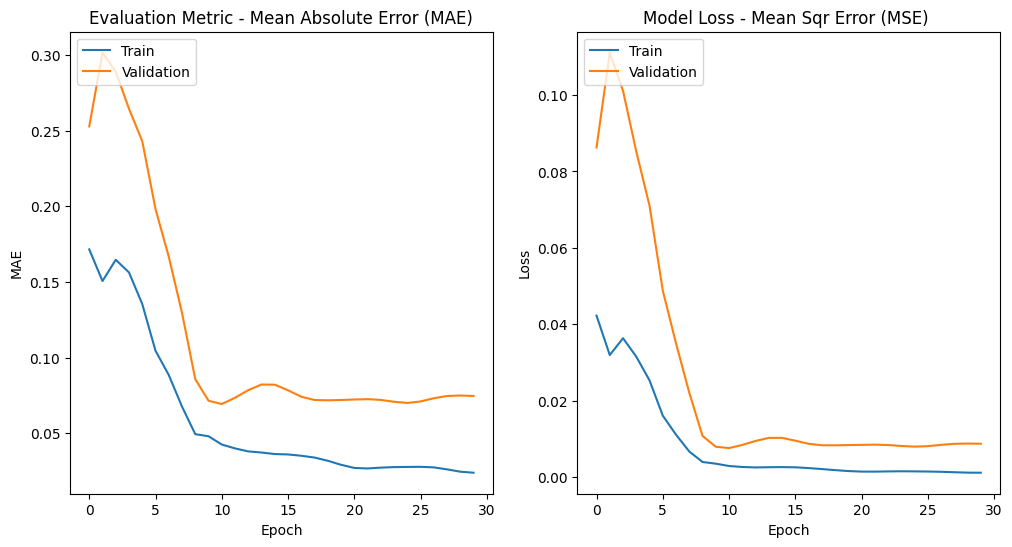

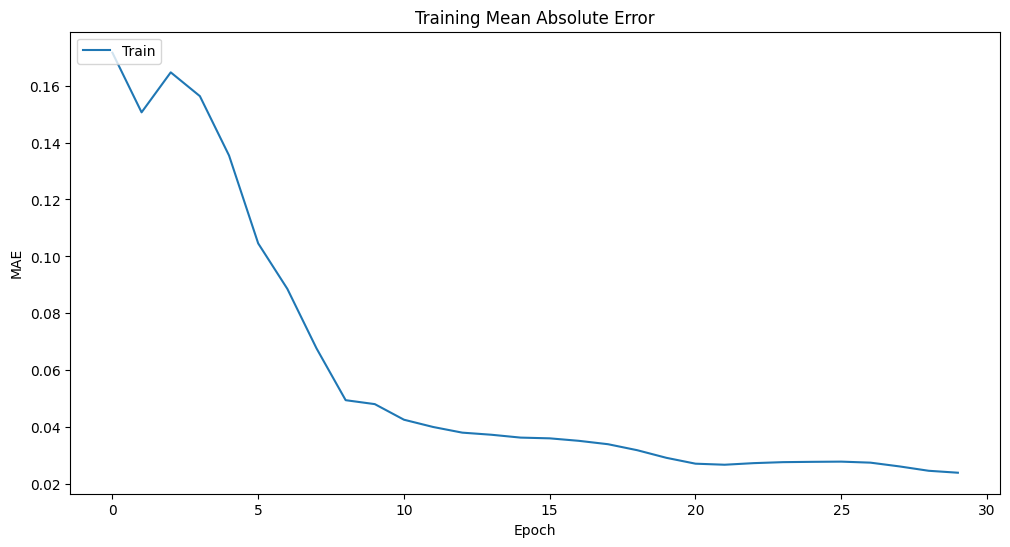

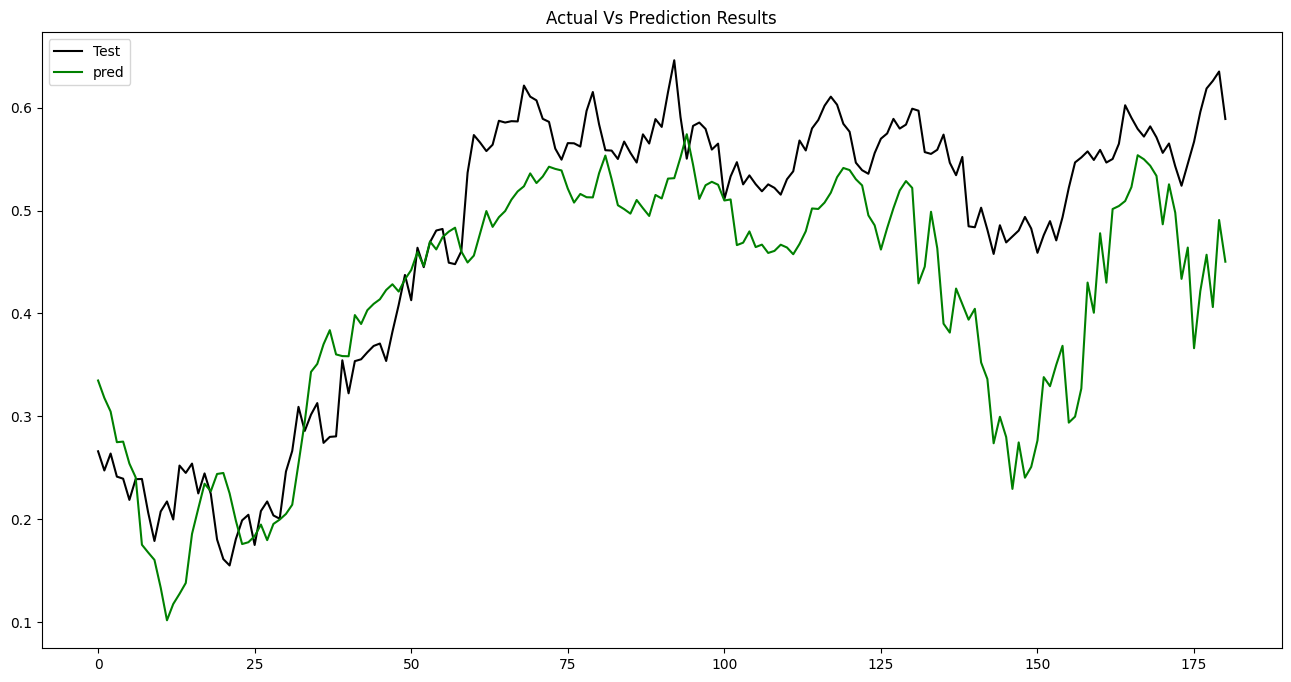

############################################################################
  Model Setup:
                    Name: BTC_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.09989029398671428
             mean_sqr_err =0.01216730425250559
        root_mean_sqr_err =0.1103055041804605
           pred_diff_mean =0.8630793502411184
      pred_diff_bias_mean =0.13692064975888174
    pred_correctness_mean =0.994475138121547
                      AIC =-756.029525645599



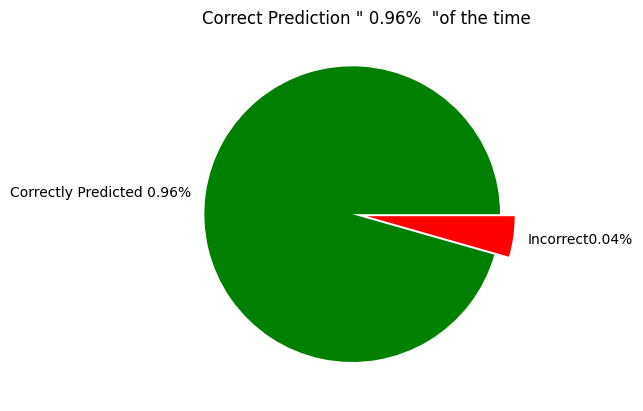

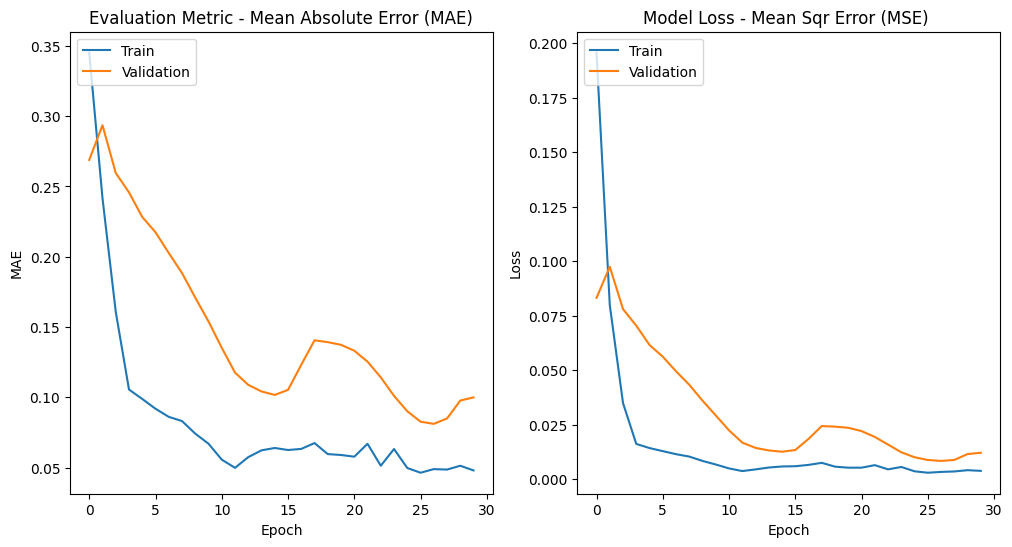

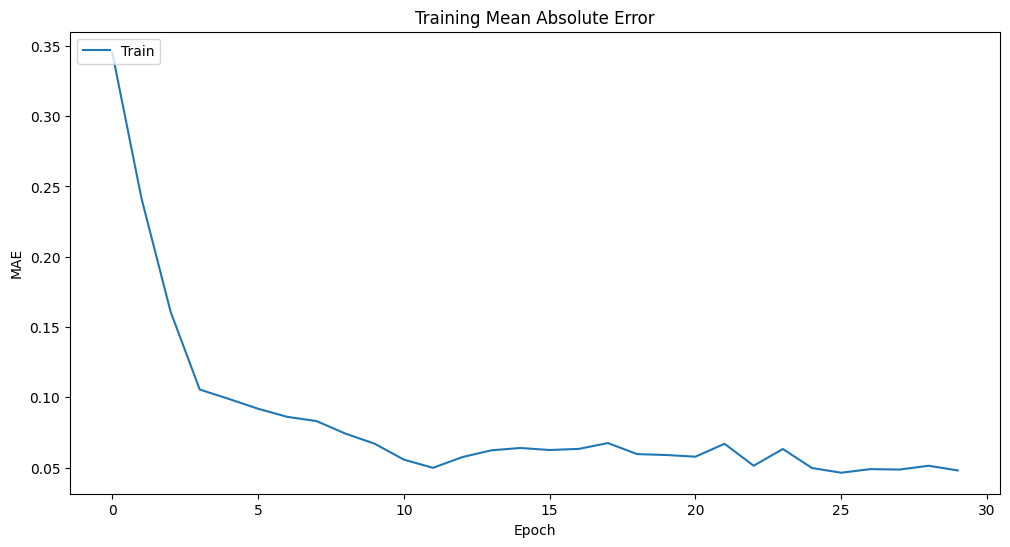

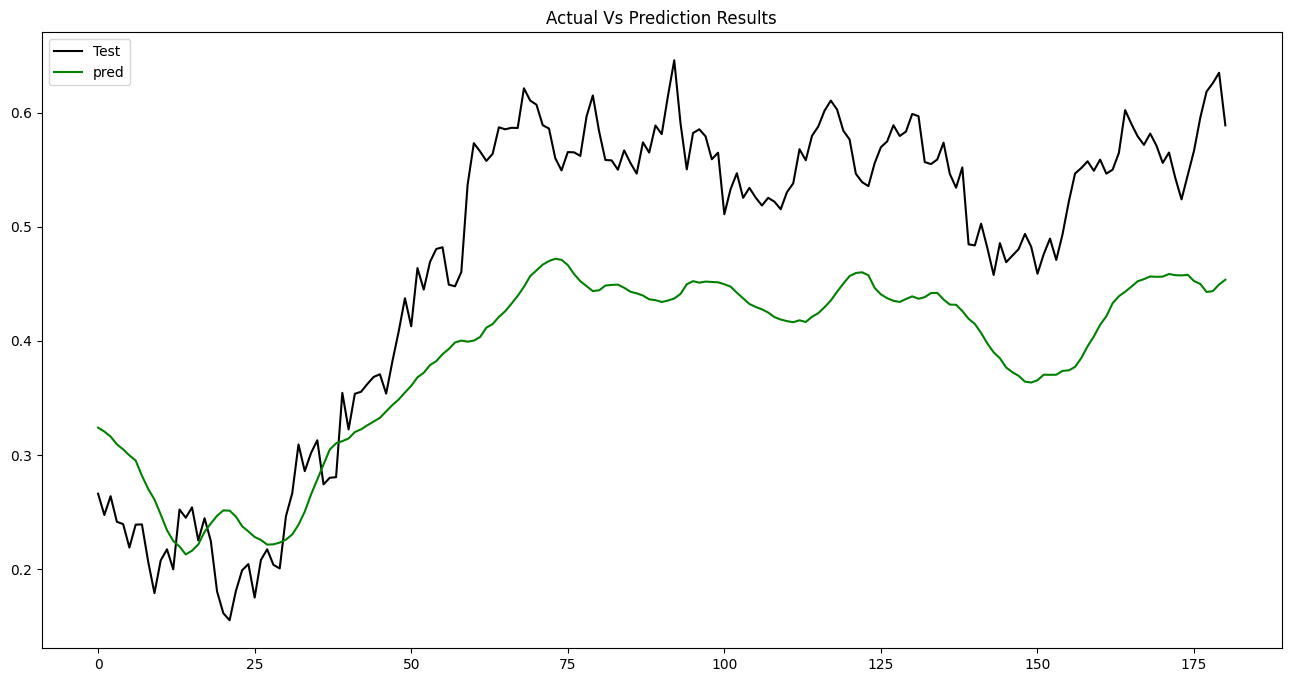

############################################################################
  Model Setup:
                    Name: BTC_F100_L1
             LSTM_Layers: 1
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.03617984615078157
             mean_sqr_err =0.001903554917509371
        root_mean_sqr_err =0.04362974807982933
           pred_diff_mean =1.0289778492540678
      pred_diff_bias_mean =-0.0289778492540679
    pred_correctness_mean =0.9815950920245399
                      AIC =-979.0372374755466



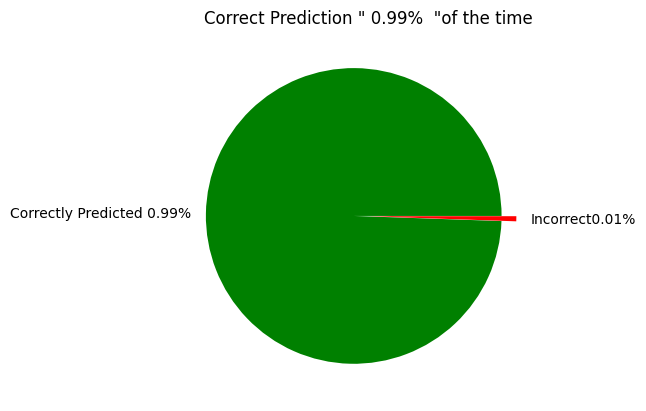

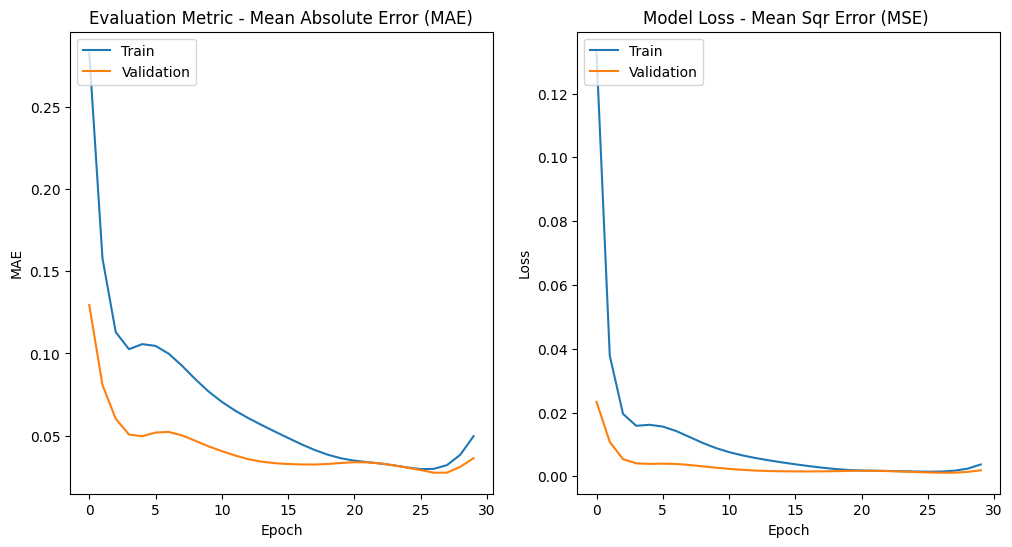

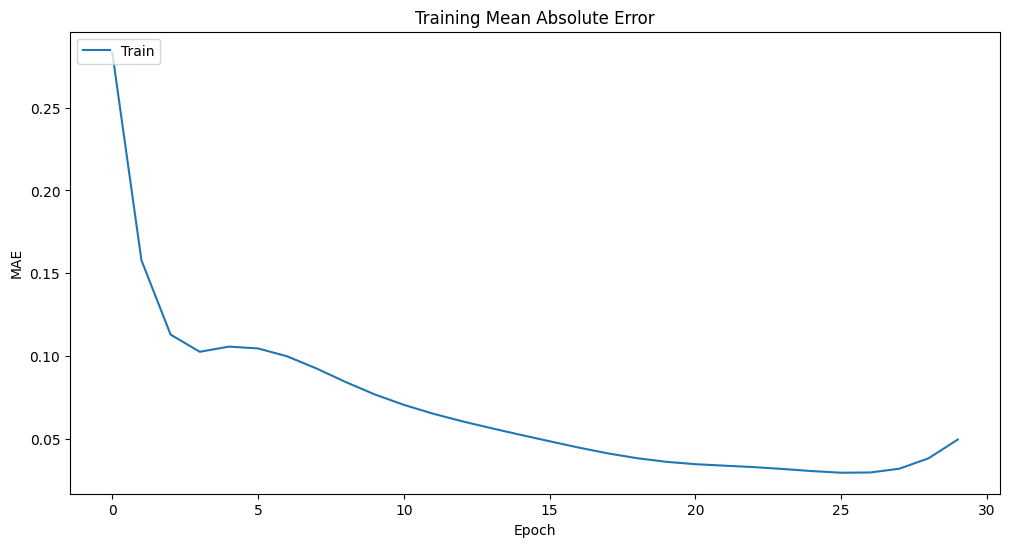

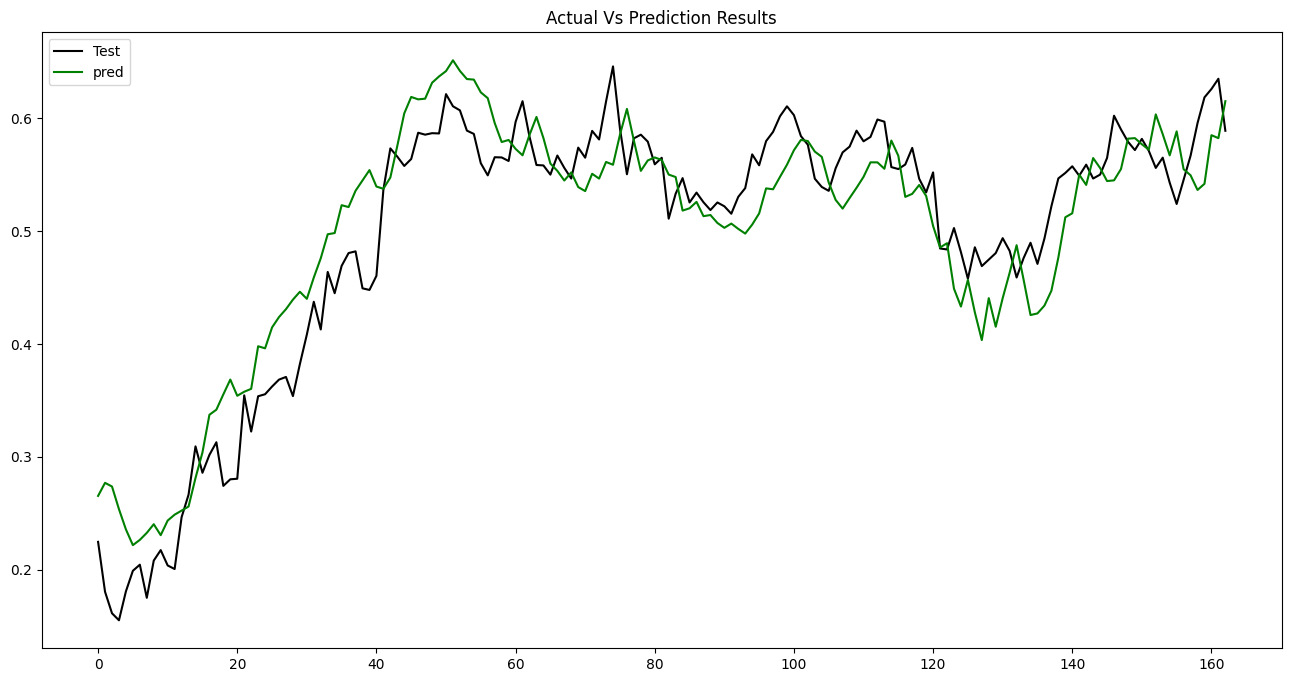

############################################################################
  Model Setup:
                    Name: BTC_F100_L2
             LSTM_Layers: 2
              LSTM_Nodes: 21
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: BTC
             Indicattors: ^DJI
              Start_Date: 2016-01-01
                End_Date: 2024-06-10
              Frame_Days: 100
  Result Data:
             mean_abs_err =0.09317361149155849
             mean_sqr_err =0.010900544560731227
        root_mean_sqr_err =0.10440567302944427
           pred_diff_mean =0.8428425434101019
      pred_diff_bias_mean =0.157157456589898
    pred_correctness_mean =0.9754601226993865
                      AIC =-694.5876326010639



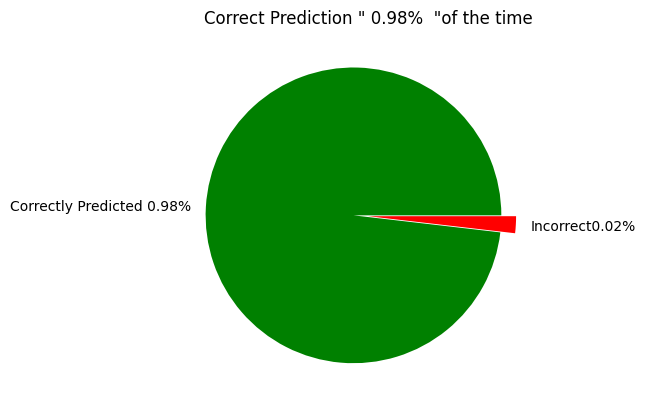

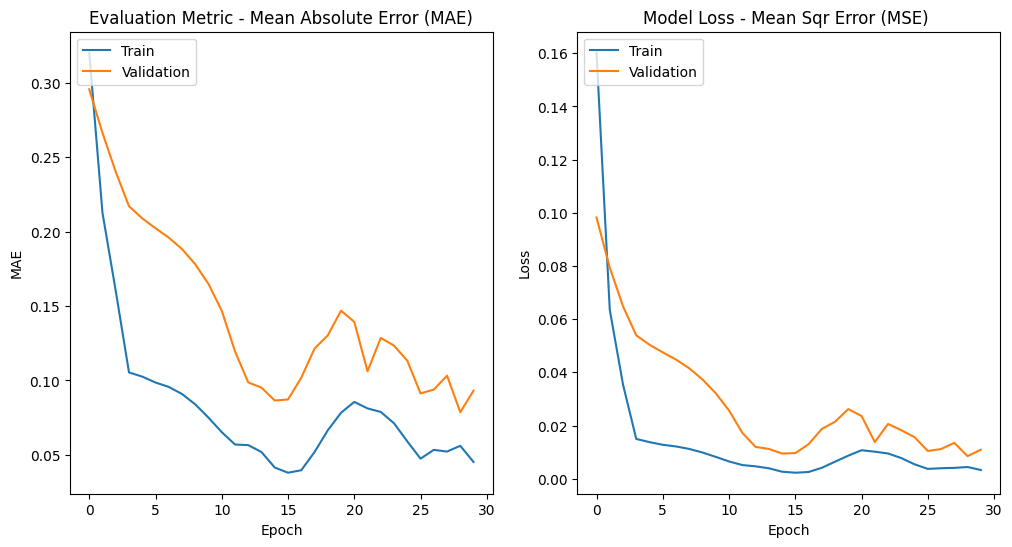

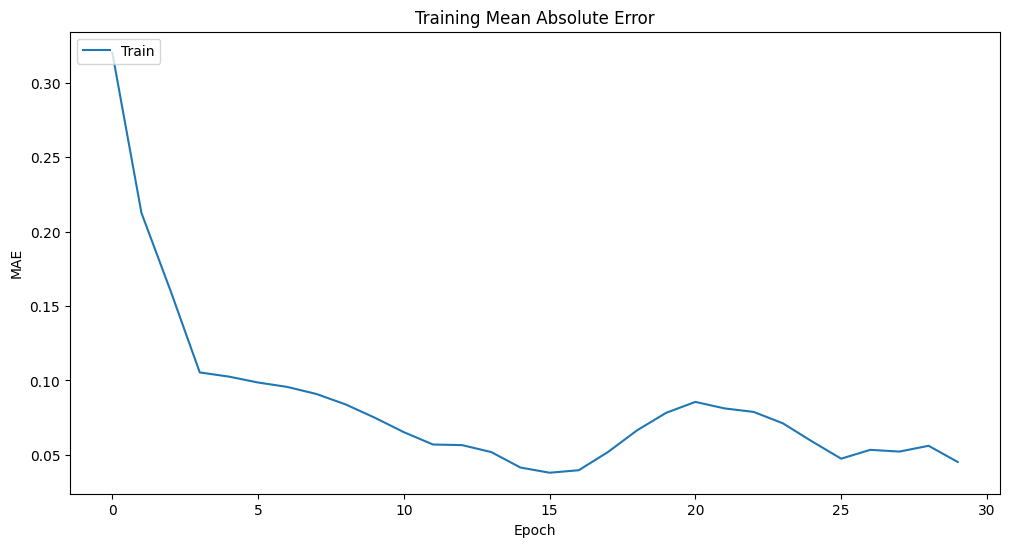

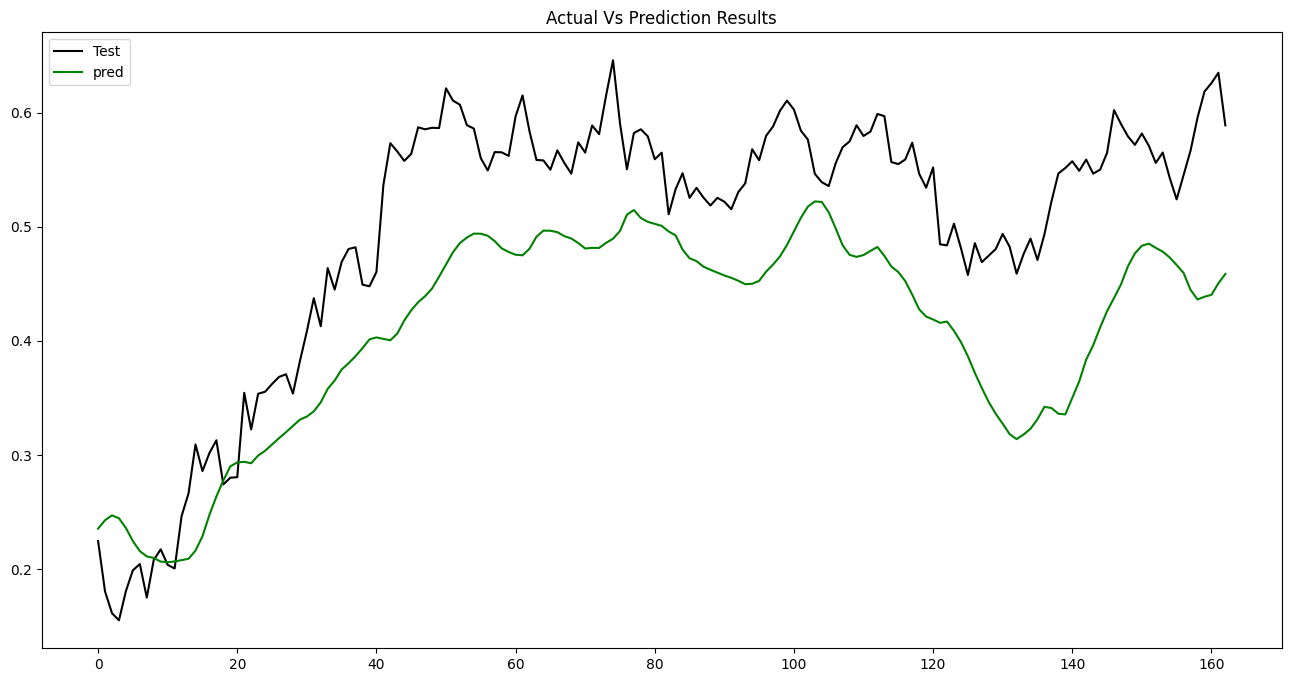

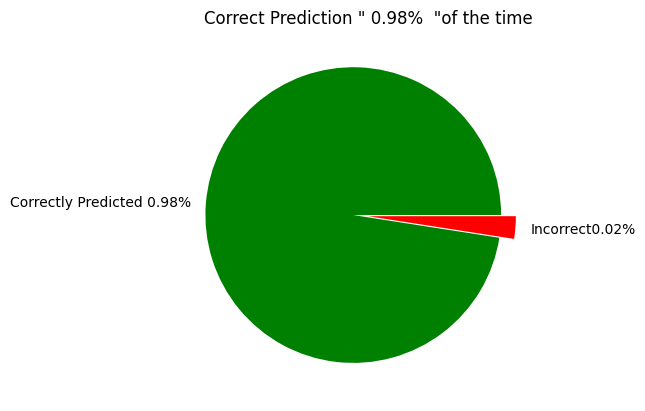

In [9]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


In [11]:
from enum import Enum

class CheckDir:
  class Direction(Enum):
    UP = 1
    DOWN = -1
    NONE = 0

  @staticmethod
  def get_direction(last:float,current:float):
    if last < current:
      return CheckDir.Direction.UP
    elif last > current:
      return CheckDir.Direction.DOWN
    else:
      return CheckDir.Direction.NONE

In [12]:
# Set Trend
data_length = len(model_list[0].y_test)
#z = model_list[0].y_test
#len(z)

model_list[0].y_pred_trend[0] = CheckDir.Direction.NONE
model_list[0].y_test_trend[0] = CheckDir.Direction.NONE

for i in range(data_length):
  if i > 0: # because we need one to compare against
    model_list[0].y_pred_trend.append(CheckDir.get_direction(model_list[0].y_pred[i-1],model_list[0].y_pred[i]))
    model_list[0].y_test_trend.append(CheckDir.get_direction(model_list[0].y_test[i-1],model_list[0].y_test[i]))

In [13]:
# Report to Visally check for Key Data Markers
#  This was used for evaluation diffrent option in how to determan accuraicy.
#  The report is not really used in any analysis, but is left here as a debuggin tool

print(f"         Predicted                                        |Key|R|Key|                         Test ")
print(f" Last  |   (trend)         |   Current   |   (trend)      |   | |   |    Last  |   (trend)         |   Current   |   (trend)         ")
for i in range(data_length):
    if i > 0: # because we need one to compare against
      PL = model_list[0].y_pred[i-1]
      PLD = model_list[0].y_pred_trend[i-1]
      PC = model_list[0].y_pred[i]
      PCD = model_list[0].y_pred_trend[i]
      if PLD == PCD:  # If trending the same not a key indicator
         PK = " "
      else:           # trending direction shifted, Key Indicator
         PK = "*"

      TL = model_list[0].y_test[i-1]
      TLD = model_list[0].y_test_trend[i-1]
      TC = model_list[0].y_test[i]
      TCD = model_list[0].y_test_trend[i]
      if TLD == TCD:        # If trending the same not a key indicator
         TK = " "
      else:                 # trending direction shifted, Key Indicator
         TK = "*"

      if PCD == TCD:          # Prediction Results Failed to Trend as Test
        R = " "
      else:
        R = "F"

      # Extract the numerical values, format them, and ensure 5 decimal places
      print(f"{PL[0]:0.5f},   {str(PLD):15s},   {PC[0]:0.5f},   {str(PCD):15s}  | {PK} |{R}| {TK} |    {TL[0]:0.5f},   {str(TLD):15s},   {TC[0]:0.5f},   {str(TCD):15s}")

    #  print(f"{model_list[0].y_pred[i-1]},   {model_list[0].y_pred_trend[i-1]}  ,   {model_list[0].y_pred[i]}")

         Predicted                                        |Key|R|Key|                         Test 
 Last  |   (trend)         |   Current   |   (trend)      |   | |   |    Last  |   (trend)         |   Current   |   (trend)         
0.33487,   Direction.NONE ,   0.31798,   Direction.DOWN   | * | | * |    0.26609,   Direction.NONE ,   0.24746,   Direction.DOWN 
0.31798,   Direction.DOWN ,   0.30472,   Direction.DOWN   |   |F| * |    0.24746,   Direction.DOWN ,   0.26392,   Direction.UP   
0.30472,   Direction.DOWN ,   0.27494,   Direction.DOWN   |   | | * |    0.26392,   Direction.UP   ,   0.24150,   Direction.DOWN 
0.27494,   Direction.DOWN ,   0.27551,   Direction.UP     | * |F|   |    0.24150,   Direction.DOWN ,   0.23948,   Direction.DOWN 
0.27551,   Direction.UP   ,   0.25416,   Direction.DOWN   | * | |   |    0.23948,   Direction.DOWN ,   0.21889,   Direction.DOWN 
0.25416,   Direction.DOWN ,   0.24079,   Direction.DOWN   |   |F| * |    0.21889,   Direction.DOWN ,   0.23898,   Di

In [15]:
#Buy and Sell Results
Shares = 1000
Cash   = 1000000
BuySellAmount = 10

data_length = len(model_list[0].y_test)
PCD = model_list[0].y_pred[0]
buy_counter = 0
sell_counter = 0
Price = model_list[0].data_set.iloc[0,0]

def buy(Shares, Cash, Price, buy_counter):
  cost = 10 * Price
  Cash = Cash - cost
  Shares = Shares + BuySellAmount
  buy_counter = buy_counter + 1
  return Shares, Cash, buy_counter

def sell(Shares, Cash, Price, sell_counter):
  cost = 10 * Price
  Cash = Cash + cost
  Shares = Shares - BuySellAmount
  sell_counter = sell_counter + 1
  return Shares, Cash, sell_counter



for i in range(data_length):
    if i > 0: # because we need one to compare against
      PCD = model_list[0].y_pred_trend[i]
      #Price = model_list[0].y_test[i]
      Price = model_list[0].data_set.iloc[i,0]


      if PCD == CheckDir.Direction.UP:  # If trending the same not a key indicator
         Shares, Cash , buy_counter= buy(Shares, Cash, Price, buy_counter)
         print(f"BUY  {model_list[0].y_test[i][0]:.4f}  Cash:{Cash:.2f}    Shares:{Shares}  Value:{((Shares * Price) + Cash):.2f}       ") # Extract the float value from the NumPy array
      elif PCD == CheckDir.Direction.DOWN:           # trending direction shifted, Key Indicator
         Shares, Cash, sell_counter = sell(Shares, Cash, Price, sell_counter)
         print(f"SELL {model_list[0].y_test[i][0]:.4f}  Cash:{Cash:.2f}    Shares:{Shares}  Value:{((Shares * Price) + Cash):.2f}        ") # Extract the float value from the NumPy array


print(f"\nFinal buy:{buy_counter}  sell:{sell_counter}  Cash:{Cash}  Shares:{Shares}  Value:{(Shares * Price) + Cash}        ")





SELL 0.2475  Cash:1000955.01    Shares:990  Value:1095501.17        
SELL 0.2639  Cash:1001910.69    Shares:980  Value:1095567.50        
SELL 0.2415  Cash:1002866.90    Shares:970  Value:1095619.09        
BUY  0.2395  Cash:1001910.98    Shares:980  Value:1095591.23       
SELL 0.2189  Cash:1002865.80    Shares:970  Value:1095483.37        
SELL 0.2390  Cash:1003819.95    Shares:960  Value:1095418.30        
SELL 0.2392  Cash:1004774.12    Shares:950  Value:1095420.60        
SELL 0.2065  Cash:1005727.94    Shares:940  Value:1095386.59        
SELL 0.1790  Cash:1006684.72    Shares:930  Value:1095665.28        
SELL 0.2076  Cash:1007641.73    Shares:920  Value:1095686.58        
SELL 0.2174  Cash:1008597.84    Shares:910  Value:1095603.90        
BUY  0.1998  Cash:1007643.25    Shares:920  Value:1095465.85       
BUY  0.2522  Cash:1006689.67    Shares:930  Value:1095372.25       
BUY  0.2451  Cash:1005735.95    Shares:940  Value:1095385.87       
BUY  0.2541  Cash:1004781.09    Shares